In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import sys
sys.path.append("../utils")
sys.path.append("../data/")
from dataconfig import *
from utils import *
import numpy as np 

{'SPARSE_FEATURES': ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26'], 'DENSE_FEATURES': ['I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'I11', 'I12', 'I13'], 'label': ['label']}


In [2]:
np.set_printoptions(precision=4, suppress=True)

In [3]:
spase_feature_names = DATA_CONFIG['SPARSE_FEATURES']
dense_feature_names = DATA_CONFIG['DENSE_FEATURES']
label_feature_names = DATA_CONFIG['label']


In [4]:

dataset = DataUtil(spase_feature_names, dense_feature_names, label_feature_names).read_tfrecord("../data/tf_data/train_criteo_5w_rows.tfrecord", 512)
eval_data = DataUtil(spase_feature_names, dense_feature_names, label_feature_names).read_tfrecord("../data/tf_data/test_criteo_1w_rows.tfrecord", 512)
valid_data = DataUtil(spase_feature_names, dense_feature_names, label_feature_names).read_tfrecord("../data/tf_data/valid_criteo_1w_rows.tfrecord", 512)
# 定义 inputs
inputs = { name:keras.Input(shape=(1,), name=name, dtype=tf.float32) for name in dense_feature_names }
inputs.update({
    name:keras.Input(shape=(1,), name=name, dtype=tf.string) for name in spase_feature_names
})

In [5]:

numeric_inputs = { name:value for name, value in inputs.items() if value.dtype == tf.float32 }
x = layers.Concatenate()(list(numeric_inputs.values()))
# 用log 处理？
# norm = layers.Normalization()
# norm.adapt(np.array(titanic[numeric_inputs.keys()]))
# x = norm(x)
preprocessed_inputs = [x]
num_bins = 10000
embedding_dim = 8
sparse_inputs = { name:value for name, value in inputs.items() if value.dtype == tf.string }
for name, input in sparse_inputs.items():
    #是否能跑通？
    lookup = keras.layers.Hashing(num_bins=num_bins)
    embedding_layer = layers.Embedding(input_dim=num_bins, output_dim=8)
    x = lookup(input)
    x = embedding_layer(x)
    x = tf.squeeze(x, axis = 1)
    preprocessed_inputs.append(x)

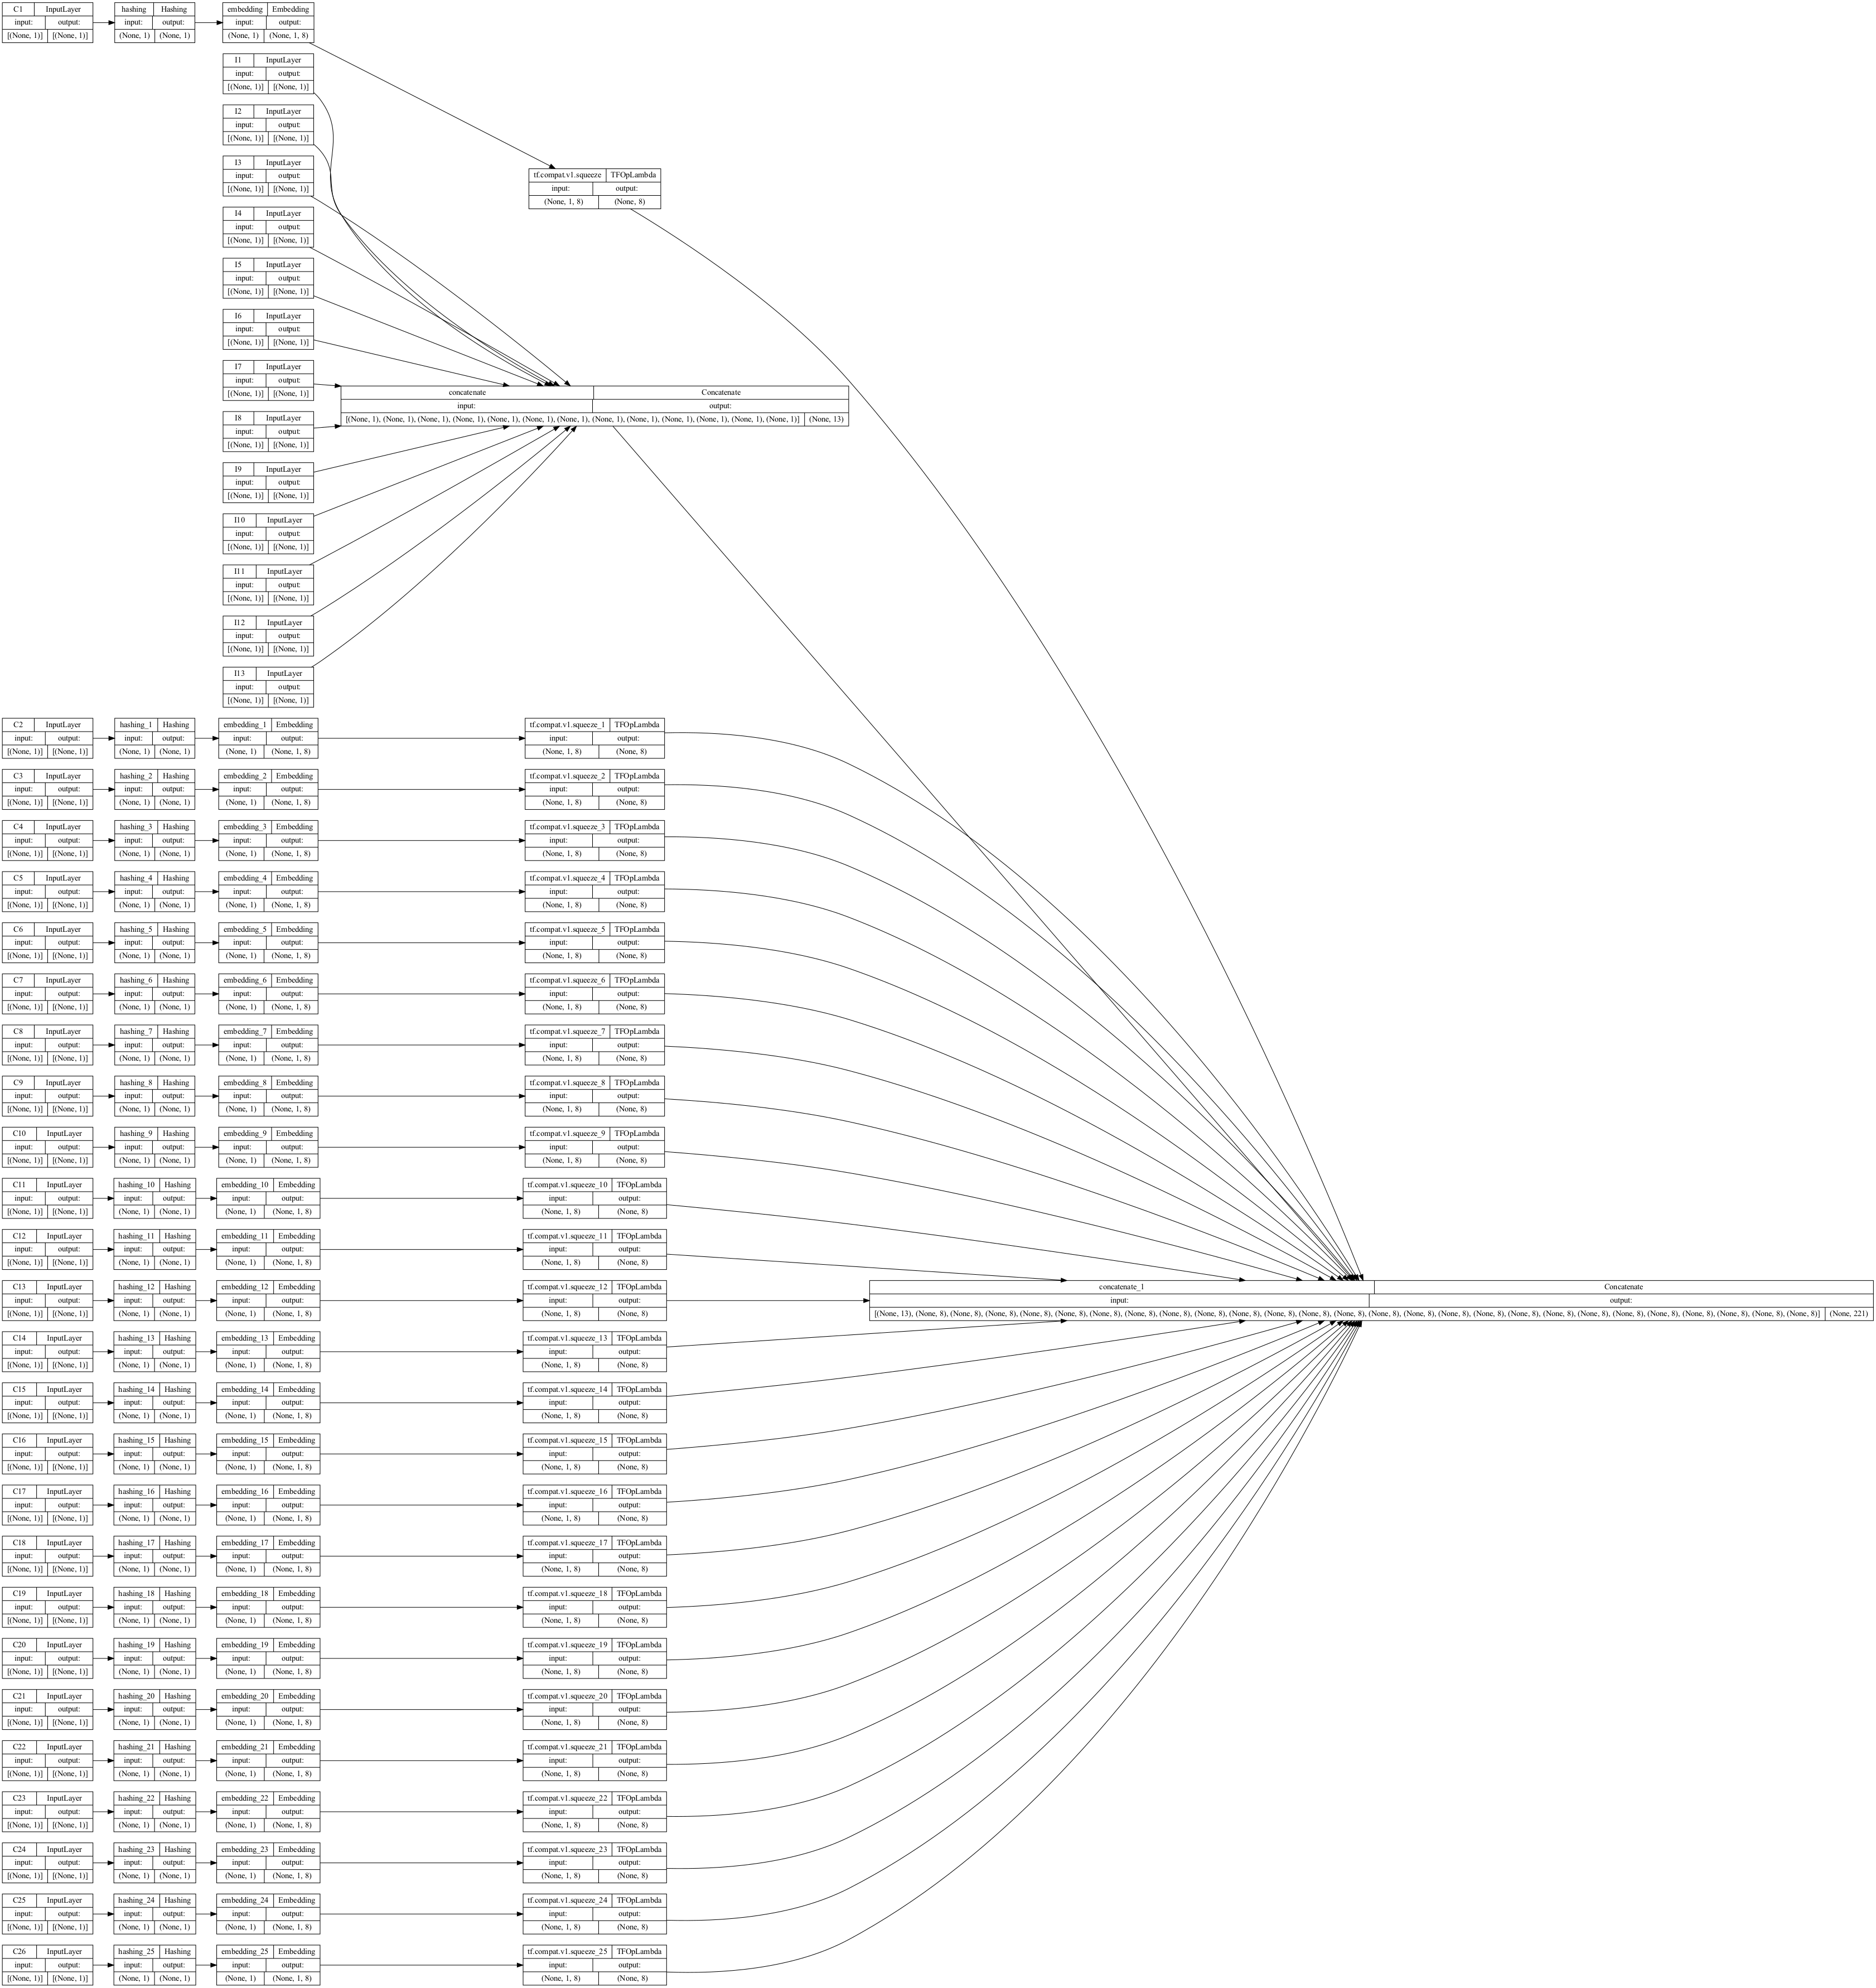

In [6]:
results = layers.Concatenate()(preprocessed_inputs)
process_model = keras.Model(inputs, results)
tf.keras.utils.plot_model(model = process_model, rankdir='LR',dpi = 75,
                         show_shapes=True )

In [7]:
import sys
sys.path.append("..")
from models.dnn_model import *

In [8]:
model = Custom_Model(process_model, [256,128, 64])

In [9]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits= False), optimizer = 'adam',metrics=[tf.keras.metrics.AUC(name='auc')])

In [10]:
def create_tf_dataset(dataset):
    def generator():
        for batch in dataset:
            data = batch
            label = batch.pop('label')
            label = tf.expand_dims(label, 1)
            # label = tf.reshape(label, (-1, 1))
            # print(label.shape)
            yield data, label  # 返回 data 和 label 作为一个 tuple
    return tf.data.Dataset.from_generator(generator, output_signature=(
        {
            name:tf.TensorSpec(shape=(None, ), dtype=v.dtype) for name, v in inputs.items()
        },
        tf.TensorSpec(shape=(None, 1), dtype=tf.float32)
    ))

In [11]:


early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc',  # 监控验证集上的 loss
    patience=3,          # 如果连续 3 轮没有改善，就停止训练
    restore_best_weights=True  # 训练结束后恢复到最优模型
)

In [12]:
model.fit(create_tf_dataset(dataset), epochs = 20,  validation_data=create_tf_dataset(valid_data), callbacks = [early_stopping])

Epoch 1/20


2025-03-12 15:53:38.607957: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


98/98 [==============================] - 13s 59ms/step - loss: 29.3192 - auc: 0.5717 - val_loss: 5.6589 - val_auc: 0.4721
Epoch 2/20
98/98 [==============================] - 9s 32ms/step - loss: 8.6318 - auc: 0.5987 - val_loss: 1.5839 - val_auc: 0.6448
Epoch 3/20
98/98 [==============================] - 15s 99ms/step - loss: 6.6007 - auc: 0.6259 - val_loss: 3.1239 - val_auc: 0.6668
Epoch 4/20
98/98 [==============================] - 8s 25ms/step - loss: 8.1146 - auc: 0.6311 - val_loss: 9.4606 - val_auc: 0.6332
Epoch 5/20
98/98 [==============================] - 15s 93ms/step - loss: 4.4670 - auc: 0.6686 - val_loss: 6.5816 - val_auc: 0.6450
Epoch 6/20
98/98 [==============================] - 8s 23ms/step - loss: 3.8252 - auc: 0.6907 - val_loss: 12.7667 - val_auc: 0.6138


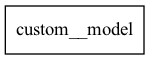

In [14]:
from tensorflow.keras.utils import plot_model

# 假设 model 已经构建完成
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True, rankdir='LR')


In [55]:
first_batch = next(iter(dataset))
input_shapes = {name: tf.TensorSpec(shape=(None,) + v.shape[1:], dtype=v.dtype) for name, v in first_batch.items() if name != 'label'}


In [15]:
# 打印每一层的详细信息
for layer in model.layers:
    print(f"Layer name: {layer.name}")
    print(f"Layer type: {layer.__class__.__name__}")
    print(f"Output shape: {layer.output_shape}")
    print(f"Parameters: {layer.count_params()}")
    print('-' * 50)


Layer name: model
Layer type: Functional
Output shape: (None, 221)
Parameters: 2080000
--------------------------------------------------
Layer name: sequential
Layer type: Sequential
Output shape: (None, 1)
Parameters: 98049
--------------------------------------------------


In [18]:
# 假设你的 model 已经定义好并且训练好了
# 创建一个 AUC 度量
auc_metric = tf.metrics.AUC()

for batch in eval_data:
    data = batch
    label = batch.pop('label')
    label = tf.expand_dims(label, 1)  # 可能需要调整 label 的形状

    # 进行预测，获取 logits
    logits = model.predict(data)

    # 将 logits 转换为概率值
    predictions = tf.sigmoid(logits)

    # 更新 AUC 度量
    auc_metric.update_state(label, predictions)

# 获取总的 AUC
total_auc = auc_metric.result().numpy()
print(f'Total AUC: {total_auc}')


9/9 [==============================] - 0s 892us/step
Total AUC: 0.6741416454315186
